In [54]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import yfinance as yf
from talib import abstract

from backtesting import Strategy, Backtest
from backtesting.lib import crossover

In [2]:
# directly import strategies
SMA = abstract.SMA
EMA = abstract.EMA
MACD = abstract.MACD
RSI = abstract.RSI
STOCH = abstract.STOCH
STOCHRSI = abstract.STOCHRSI

## Getting Data from Yahoo Example
Additional info: https://pypi.org/project/yfinance/

In [284]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# can also use specify: data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30")
# S&P500 index: ^GSPC
stock = yf.Ticker("SPY")

# one way to get data for period of interest
df = stock.history(period="16y")
df

# Other potential fields of interest
# stock.info
# stock.major_holders
# stock.recommendations
# stock.options

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-03-02,87.755898,88.606132,87.675961,88.053841,64226500,0.0,0
2005-03-03,88.409943,88.584349,87.712309,88.090195,61230800,0.0,0
2005-03-04,88.693316,89.260138,88.504373,89.187469,56168500,0.0,0
2005-03-07,89.136595,89.565344,88.947653,89.231064,43442400,0.0,0
2005-03-08,89.143856,89.383667,88.736908,88.896782,44362000,0.0,0
...,...,...,...,...,...,...,...
2021-02-23,384.660004,388.950012,380.200012,387.500000,107284100,0.0,0
2021-02-24,386.329987,392.230011,385.269989,391.769989,72433900,0.0,0
2021-02-25,390.410004,391.880005,380.779999,382.329987,146670500,0.0,0


## EDA

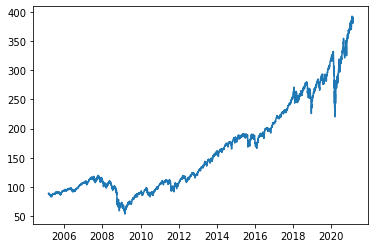

In [285]:
# Simple stock chart based on API data
plt.plot(df.Close)

### Adding Returns Data

In [286]:
# Daily return based on Close price
df["Return"] = df["Close"] - df["Close"].shift(1)
df["Return%"] = df["Return"] / df["Close"].shift(1)

# Last 5 day return based on Close price
df["L5D_Return"] = df["Close"] - df["Close"].shift(5)
df["L5D_Return%"] = df["L5D_Return"] / df["Close"].shift(5)

# Next 5 day return based on Close price
df["N5D_Return"] = (df["Close"] - df["Close"].shift(-5)) * -1
df["N5D_Return%"] = df["N5D_Return"] / df["Close"]

# Next 5 day return based on Open price next day
df["N5D_Return_Delayed"] = (df["Open"].shift(-1) - df["Close"].shift(-5)) * -1
df["N5D_Return_Delayed%"] = df["N5D_Return_Delayed"] / df["Open"].shift(-1)

df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,L5D_Return,L5D_Return%,N5D_Return,N5D_Return%,N5D_Return_Delayed,N5D_Return_Delayed%
Date,,,,,,,,,,,,,,,
2005-03-02,87.755898,88.606132,87.675961,88.053841,64226500,0.0,0,NaN,NaN,NaN,NaN,-0.145340,-0.001651,-0.501442,-0.005672
2005-03-03,88.409943,88.584349,87.712309,88.090195,61230800,0.0,0,0.036354,0.000413,NaN,NaN,0.014519,0.000165,-0.588602,-0.006636
2005-03-04,88.693316,89.260138,88.504373,89.187469,56168500,0.0,0,1.097275,0.012456,NaN,NaN,-1.700508,-0.019067,-1.649634,-0.018507
2005-03-07,89.136595,89.565344,88.947653,89.231064,43442400,0.0,0,0.043594,0.000489,NaN,NaN,-1.199020,-0.013437,-1.111813,-0.012472
2005-03-08,89.143856,89.383667,88.736908,88.896782,44362000,0.0,0,-0.334282,-0.003746,NaN,NaN,-1.591454,-0.017902,-1.329869,-0.015004
2005-03-09,88.635197,88.867740,87.901232,87.908501,73263600,0.0,0,-0.988281,-0.011117,-0.145340,-0.001651,-1.344391,-0.015293,-1.511535,-0.017162
2005-03-10,88.075645,88.293656,87.494291,88.104713,65149000,0.0,0,0.196213,0.002232,0.014519,0.000165,-1.366211,-0.015507,-1.417018,-0.016074
2005-03-11,88.155521,88.453469,87.319824,87.486961,57976500,0.0,0,-0.617752,-0.007012,-1.700508,-0.019067,-1.006004,-0.011499,-1.165938,-0.013303
2005-03-14,87.646895,88.046580,87.407084,88.032043,36336400,0.0,0,0.545082,0.006230,-1.199020,-0.013437,-1.872078,-0.021266,-2.075534,-0.023523


### Adding Common Technical Levels/Signals to the Data

In [287]:
# Close price as a % of 52-Week high and low
df["52Wk_High"] = df["Close"].rolling(min_periods=252, window=252).max()
df["52Wk_Low"] = df["Close"].rolling(min_periods=252, window=252).min()
df["%52Wk_High"] = df["Close"] / df["52Wk_High"]
df["%52Wk_Low"] = df["Close"] / df["52Wk_Low"]

# Open price as a % of prior Close
df["Open%PriorClose"] = df["Open"] / df["Close"].shift(1)

# Close price as a % of Open, High, and Low
df["Close%Open"] = df["Close"] / df["Open"]
df["Close%High"] = df["Close"] / df["High"]
df["Close%Low"] = df["Close"] / df["Low"]

# Dividend as a % of Close
df["Div%Close"] = df["Dividends"] / df["Close"]

# Volume as a % of 52-Week average volume
df["52Wk_Avg_Volume"] = df["Volume"].rolling(min_periods=252, window=252).mean()
df["%52Wk_Avg_Volume"] = df["Volume"] / df["52Wk_Avg_Volume"]

# Add simple moving averages (SMAs)
df["SMA3"] = SMA(df.Close, 3)
df["SMA5"] = SMA(df.Close, 5)
df["SMA10"] = SMA(df.Close, 10)
df["SMA15"] = SMA(df.Close, 15)
df["SMA20"] = SMA(df.Close, 20)
df["SMA30"] = SMA(df.Close, 30)
df["SMA50"] = SMA(df.Close, 50)

# Standardized % above or below simple trading averages
df["SMA3%"] = df["Close"] / df["SMA3"] - 1
df["SMA5%"] = df["Close"] / df["SMA5"] - 1
df["SMA10%"] = df["Close"] / df["SMA10"] - 1
df["SMA15%"] = df["Close"] / df["SMA15"] - 1
df["SMA20%"] = df["Close"] / df["SMA20"] - 1
df["SMA30%"] = df["Close"] / df["SMA30"] - 1
df["SMA50%"] = df["Close"] / df["SMA50"] - 1

# Add exponential moving averages (EMAs)
# More info: https://www.investopedia.com/terms/e/ema.asp
df["EMA3"] = EMA(df.Close, 3)
df["EMA5"] = EMA(df.Close, 5)
df["EMA10"] = EMA(df.Close, 10)
df["EMA15"] = EMA(df.Close, 15)
df["EMA20"] = EMA(df.Close, 20)
df["EMA30"] = EMA(df.Close, 30)
df["EMA50"] = EMA(df.Close, 50)

# Standardized % above or below exponential trading averages
df["EMA3%"] = df["Close"] / df["EMA3"] - 1
df["EMA5%"] = df["Close"] / df["EMA5"] - 1
df["EMA10%"] = df["Close"] / df["EMA10"] - 1
df["EMA15%"] = df["Close"] / df["EMA15"] - 1
df["EMA20%"] = df["Close"] / df["EMA20"] - 1
df["EMA30%"] = df["Close"] / df["EMA30"] - 1
df["EMA50%"] = df["Close"] / df["EMA50"] - 1

# Add pivot point (PP) and classical support and resistance pivot points
# More info: https://www.investopedia.com/terms/p/pivotpoint.asp
df["PP"] = (df.High + df.Low + df.Close) / 3
df["S1C"] = df.PP * 2 - df.High
df["S2C"] = df.PP - (df.High - df.Low)
df["S3C"] = df.Low - 2 * (df.High - df.PP)
df["R1C"] = df.PP * 2 - df.Low 
df["R2C"] = df.PP + (df.High - df.Low)
df["R3C"] = df.High + 2 * (df.PP - df.Low)

# Standardized % above or below classical pivot points
df["PP%"] = df["Close"] / df["PP"] - 1
df["S1C%"] = df["Close"] / df["S1C"] - 1
df["S2C%"] = df["Close"] / df["S2C"] - 1
df["S3C%"] = df["Close"] / df["S3C"] - 1
df["R1C%"] = df["Close"] / df["R1C"] - 1
df["R2C%"] = df["Close"] / df["R2C"] - 1
df["R3C%"] = df["Close"] / df["R3C"] - 1

# Add Fibonacci support and resistance pivot points
# More info: https://www.interactivebrokers.com/en/software/tws/usersguidebook/technicalanalytics/fibonaccipivotpoints.htm
df["S1F"] = df.PP - 0.382 * (df.High - df.Low)
df["S2F"] = df.PP - 0.618 * (df.High - df.Low)
df["S3F"] = df.PP - 1.0 * (df.High - df.Low)
df["R1F"] = df.PP + 0.382 * (df.High - df.Low)
df["R2F"] = df.PP + 0.618 * (df.High - df.Low)
df["R3F"] = df.PP + 1.0 * (df.High - df.Low)

# Standardized % above or Fibonacci classical pivot points
df["S1F%"] = df["Close"] / df["S1F"] - 1
df["S2F%"] = df["Close"] / df["S2F"] - 1
df["S3F%"] = df["Close"] / df["S3F"] - 1
df["R1F%"] = df["Close"] / df["R1F"] - 1
df["R2F%"] = df["Close"] / df["R2F"] - 1
df["R3F%"] = df["Close"] / df["R3F"] - 1

### Adding Other Trading Signals to the Data

In [288]:
# Add SMA Crossing Signal
sma_fast = SMA(df.Close, 3)
sma_slow = SMA(df.Close, 15)
sma_signal = pd.Series(sma_fast > sma_slow).astype(int).diff().fillna(0)
df["SMA_Signal"] = sma_signal.values

# Add MACD Signal
macd, macdsignal, macdhist = MACD(df.Close, fastperiod=12, slowperiod=26, signalperiod=9)
macd_signal = pd.Series(macd > macdsignal).astype(int).diff().fillna(0)
df["MACD_Signal"] = macd_signal.values

# Add RSI Level and Signal
real = RSI(df.Close, timeperiod=14)
df["RSI"] = real
overbought = 70
oversold = 30
buy_signal = pd.Series(real <= oversold).astype(int)
sell_signal = pd.Series(real >= overbought).astype(int) * -1
rsi_signal = buy_signal + sell_signal
df["RSI_Signal"] = rsi_signal.values

# Add Stochastic Oscillator levels
slowk, slowd = STOCH(df.High, df.Low, df.Close, 
                     fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
overbought = 80
oversold = 20
buy_signal = pd.Series(slowk <= oversold).astype(int) + pd.Series(slowd <= oversold).astype(int)
sell_signal = pd.Series(slowk >= overbought).astype(int) * -1 + pd.Series(slowd >= overbought).astype(int) * -1
stoch_signal = buy_signal + sell_signal
df["Slow_K"] = slowk
df["Slow_D"] = slowd
df["Stoch_Osci"] = stoch_signal.values

# Add Stochastic RSI levels
fastk, fastd = STOCHRSI(df.Close, timeperiod=14, fastk_period=14, fastd_period=3, fastd_matype=0)
overbought = 80
oversold = 20
buy_signal = pd.Series(fastk <= oversold).astype(int) + pd.Series(fastd <= oversold).astype(int)
sell_signal = pd.Series(fastk >= overbought).astype(int) * -1 + pd.Series(fastd >= overbought).astype(int) * -1
stoch_signal = buy_signal + sell_signal
df["Fast_K"] = fastk
df["Fast_D"] = fastd
df["Stoch_RSI"] = stoch_signal.values

print(df.shape)
df.describe()

(4027, 90)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,L5D_Return,...,SMA_Signal,MACD_Signal,RSI,RSI_Signal,Slow_K,Slow_D,Stoch_Osci,Fast_K,Fast_D,Stoch_RSI
count,4027.000000,4027.000000,4027.000000,4027.000000,4.027000e+03,4027.000000,4027.0,4026.000000,4026.000000,4022.000000,...,4027.000000,4027.000000,4013.000000,4027.000000,4010.000000,4010.000000,4027.000000,3998.000000,3.998000e+03,4027.000000
mean,162.964601,163.862938,161.972944,162.975906,1.379465e+08,0.014225,0.0,0.074895,0.000446,0.369985,...,0.000000,0.000000,55.528034,-0.068289,64.031453,64.023727,-0.621803,56.306617,5.631835e+01,-0.270425
std,78.403099,78.756519,77.998668,78.407443,9.726681e+07,0.118983,0.0,2.079847,0.012386,4.276078,...,0.294847,0.286299,11.422571,0.313712,27.876917,26.960430,1.202023,35.955778,3.238033e+01,1.361462
min,53.378173,54.988555,52.710454,53.503864,1.527000e+07,0.000000,0.0,-28.929718,-0.109424,-53.353622,...,-1.000000,-1.000000,16.802669,-1.000000,0.850531,1.264114,-2.000000,0.000000,-3.138230e-14,-2.000000
25%,98.569232,99.455608,97.876698,98.629597,7.088280e+07,0.000000,0.0,-0.555777,-0.003775,-1.072933,...,0.000000,0.000000,47.409063,0.000000,40.627599,41.336267,-2.000000,24.246156,2.698348e+01,-2.000000
50%,130.538493,131.017419,129.760174,130.786499,1.072760e+08,0.000000,0.0,0.101665,0.000716,0.575966,...,0.000000,0.000000,56.770041,0.000000,72.460950,71.815961,0.000000,60.333697,5.885600e+01,0.000000
75%,218.002211,218.853443,217.092973,217.991837,1.731658e+08,0.000000,0.0,0.811766,0.005632,2.096977,...,0.000000,0.000000,64.130809,0.000000,89.073128,88.039643,0.000000,92.775233,8.785527e+01,1.000000
max,393.959991,394.170013,391.529999,392.640015,8.710263e+08,1.580000,0.0,20.821152,0.145198,38.213928,...,1.000000,1.000000,87.191112,1.000000,99.937681,98.697086,2.000000,100.000000,1.000000e+02,2.000000


### Adding Labels for Buy and Sell Based on Return

In [289]:
# Add Buy and Sell labels based on return, using the following metrics and thresholds
return_metric = df["N5D_Return_Delayed%"]
buy_threshold = 0.005
sell_threshold = -0.005

buy_signal = pd.Series(return_metric >= buy_threshold).astype(int)
sell_signal = pd.Series(return_metric <= sell_threshold).astype(int) * -1
labels = buy_signal + sell_signal
df["Labels"] = labels.values

# Drop NA rows where metrics cannot be computed (beginning and end of the dataframe)
# Drops about a year plus a few days of data
df.dropna(axis=0, how='any', inplace=True)

df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,L5D_Return,...,MACD_Signal,RSI,RSI_Signal,Slow_K,Slow_D,Stoch_Osci,Fast_K,Fast_D,Stoch_RSI,Labels
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-01,95.101382,95.759548,95.027427,95.670799,48641600,0.0,0,0.843063,0.008890,0.073959,...,0.0,58.204110,0,77.823155,82.703281,-1,78.809628,71.207334,0,-1
2006-03-02,95.323180,95.707730,95.108726,95.663361,60642300,0.0,0,-0.007439,-0.000078,0.207039,...,0.0,58.133557,0,77.051037,78.560177,0,78.224030,64.240063,0,-1
2006-03-03,95.153112,96.188437,95.138319,95.219666,73402500,0.0,0,-0.443695,-0.004638,-0.480690,...,0.0,53.934039,0,79.596842,78.157012,0,48.512262,68.515307,0,0
2006-03-06,95.500699,95.530275,94.546727,94.783371,57478400,0.0,0,-0.436295,-0.004582,-0.953995,...,-1.0,50.101363,0,68.054960,74.900946,0,0.000000,42.245431,1,1
2006-03-07,94.554136,94.702036,94.213961,94.635483,61780800,0.0,0,-0.147888,-0.001560,-0.192253,...,0.0,48.834573,0,48.258817,65.303540,0,0.000000,16.170754,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-16,393.959991,394.170013,391.529999,392.299988,50972400,0.0,0,-0.340027,-0.000866,1.789978,...,0.0,66.107535,0,95.061774,94.432959,-2,97.054203,96.062570,-2,-1
2021-02-17,390.420013,392.660004,389.329987,392.390015,52290600,0.0,0,0.090027,0.000229,2.140015,...,0.0,66.208281,0,94.950572,94.808848,-2,97.479058,98.177753,-2,1
2021-02-18,389.589996,391.519989,387.739990,390.720001,59712800,0.0,0,-1.670013,-0.004256,0.640015,...,0.0,62.497058,0,90.862252,93.624866,-2,81.828503,92.120588,-2,-1


In [290]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Return', 'Return%', 'L5D_Return', 'L5D_Return%', 'N5D_Return',
       'N5D_Return%', 'N5D_Return_Delayed', 'N5D_Return_Delayed%', '52Wk_High',
       '52Wk_Low', '%52Wk_High', '%52Wk_Low', 'Open%PriorClose', 'Close%Open',
       'Close%High', 'Close%Low', 'Div%Close', '52Wk_Avg_Volume',
       '%52Wk_Avg_Volume', 'SMA3', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA30',
       'SMA50', 'SMA3%', 'SMA5%', 'SMA10%', 'SMA15%', 'SMA20%', 'SMA30%',
       'SMA50%', 'EMA3', 'EMA5', 'EMA10', 'EMA15', 'EMA20', 'EMA30', 'EMA50',
       'EMA3%', 'EMA5%', 'EMA10%', 'EMA15%', 'EMA20%', 'EMA30%', 'EMA50%',
       'PP', 'S1C', 'S2C', 'S3C', 'R1C', 'R2C', 'R3C', 'PP%', 'S1C%', 'S2C%',
       'S3C%', 'R1C%', 'R2C%', 'R3C%', 'S1F', 'S2F', 'S3F', 'R1F', 'R2F',
       'R3F', 'S1F%', 'S2F%', 'S3F%', 'R1F%', 'R2F%', 'R3F%', 'SMA_Signal',
       'MACD_Signal', 'RSI', 'RSI_Signal', 'Slow_K', 'Slow_D', 'Stoch_Osci',
       'Fast_K'

In [291]:
df.to_csv("example_data.csv")

In [292]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,L5D_Return,...,MACD_Signal,RSI,RSI_Signal,Slow_K,Slow_D,Stoch_Osci,Fast_K,Fast_D,Stoch_RSI,Labels
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-01,95.101382,95.759548,95.027427,95.670799,48641600,0.0,0,0.843063,0.008890,0.073959,...,0.0,58.204110,0,77.823155,82.703281,-1,78.809628,71.207334,0,-1
2006-03-02,95.323180,95.707730,95.108726,95.663361,60642300,0.0,0,-0.007439,-0.000078,0.207039,...,0.0,58.133557,0,77.051037,78.560177,0,78.224030,64.240063,0,-1
2006-03-03,95.153112,96.188437,95.138319,95.219666,73402500,0.0,0,-0.443695,-0.004638,-0.480690,...,0.0,53.934039,0,79.596842,78.157012,0,48.512262,68.515307,0,0
2006-03-06,95.500699,95.530275,94.546727,94.783371,57478400,0.0,0,-0.436295,-0.004582,-0.953995,...,-1.0,50.101363,0,68.054960,74.900946,0,0.000000,42.245431,1,1
2006-03-07,94.554136,94.702036,94.213961,94.635483,61780800,0.0,0,-0.147888,-0.001560,-0.192253,...,0.0,48.834573,0,48.258817,65.303540,0,0.000000,16.170754,2,1


In [293]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,L5D_Return,...,MACD_Signal,RSI,RSI_Signal,Slow_K,Slow_D,Stoch_Osci,Fast_K,Fast_D,Stoch_RSI,Labels
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-16,393.959991,394.170013,391.529999,392.299988,50972400,0.0,0,-0.340027,-0.000866,1.789978,...,0.0,66.107535,0,95.061774,94.432959,-2,97.054203,96.062570,-2,-1
2021-02-17,390.420013,392.660004,389.329987,392.390015,52290600,0.0,0,0.090027,0.000229,2.140015,...,0.0,66.208281,0,94.950572,94.808848,-2,97.479058,98.177753,-2,1
2021-02-18,389.589996,391.519989,387.739990,390.720001,59712800,0.0,0,-1.670013,-0.004256,0.640015,...,0.0,62.497058,0,90.862252,93.624866,-2,81.828503,92.120588,-2,-1
2021-02-19,392.070007,392.380005,389.549988,390.029999,83241000,0.0,0,-0.690002,-0.001766,-0.679993,...,0.0,60.976228,0,87.468200,91.093675,-2,63.114300,80.807287,-1,-1
2021-02-22,387.059998,389.619995,386.739990,387.029999,67414200,0.0,0,-3.000000,-0.007692,-5.610016,...,-1.0,54.739236,0,76.425703,84.918719,-1,0.000000,48.314268,1,1


### Returns and Signal Visualizations

(array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 4.000e+00, 8.000e+00, 1.500e+01, 1.500e+01,
        3.600e+01, 7.800e+01, 1.370e+02, 3.010e+02, 7.750e+02, 1.369e+03,
        6.230e+02, 2.380e+02, 7.800e+01, 3.300e+01, 1.800e+01, 1.400e+01,
        4.000e+00, 4.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.10942365, -0.10305812, -0.09669259, -0.09032706, -0.08396153,
        -0.077596  , -0.07123047, -0.06486494, -0.05849941, -0.05213388,
        -0.04576835, -0.03940282, -0.03303729, -0.02667176, -0.02030623,
        -0.0139407 , -0.00757517, -0.00120964,  0.00515589,  0.01152142,
         0.01788695,  0.02425248,  0.03061801,  0.03698354,  0.04334907,
         0.0497146 ,  0.05608013,  0.06244566,  0.06881119,  0.07517672,
         0.08154225,  0.08790778,  0.09427331,  0.10063884,  0.1

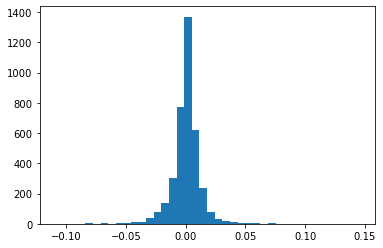

In [294]:
plt.hist(df["Return%"], bins=40)

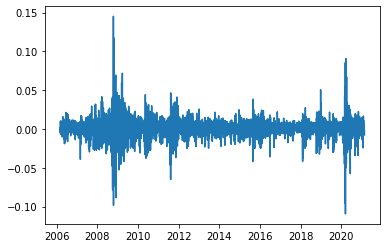

In [295]:
plt.plot(df["Return%"])

(array([  1.,   0.,   1.,   0.,   4.,   0.,   1.,   1.,   1.,   2.,   4.,
          6.,   8.,  12.,  18.,  23.,  59.,  70., 151., 220., 384., 694.,
        866., 649., 295., 139.,  77.,  30.,  18.,  18.,   3.,   3.,   1.,
          2.,   6.,   2.,   0.,   0.,   1.,   1.]),
 array([-0.19634986, -0.18736481, -0.17837977, -0.16939472, -0.16040968,
        -0.15142463, -0.14243959, -0.13345454, -0.12446949, -0.11548445,
        -0.1064994 , -0.09751436, -0.08852931, -0.07954427, -0.07055922,
        -0.06157418, -0.05258913, -0.04360409, -0.03461904, -0.02563399,
        -0.01664895, -0.0076639 ,  0.00132114,  0.01030619,  0.01929123,
         0.02827628,  0.03726132,  0.04624637,  0.05523141,  0.06421646,
         0.0732015 ,  0.08218655,  0.0911716 ,  0.10015664,  0.10914169,
         0.11812673,  0.12711178,  0.13609682,  0.14508187,  0.15406691,
         0.16305196]),
 <BarContainer object of 40 artists>)

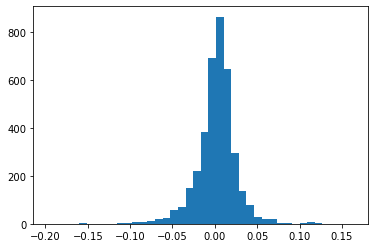

In [296]:
plt.hist(df["N5D_Return_Delayed%"], bins=40)

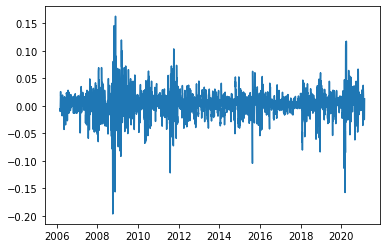

In [297]:
plt.plot(df["N5D_Return_Delayed%"])

(array([1128.,    0.,    0.,    0.,    0.,  876.,    0.,    0.,    0.,
        1767.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

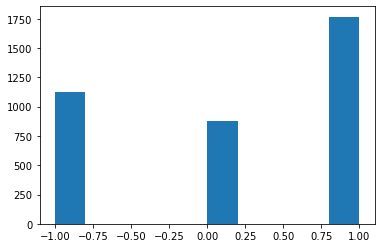

In [298]:
# Response variable
plt.hist(df.Labels)

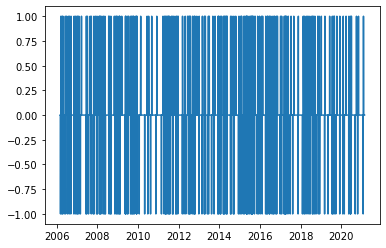

In [299]:
# Take a look at an example signal plot
plt.plot(df.SMA_Signal)

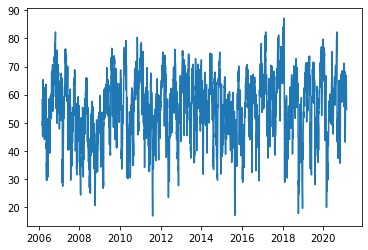

In [300]:
plt.plot(df.RSI)

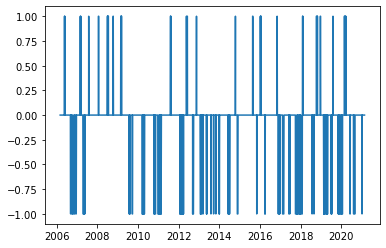

In [301]:
plt.plot(df.RSI_Signal)

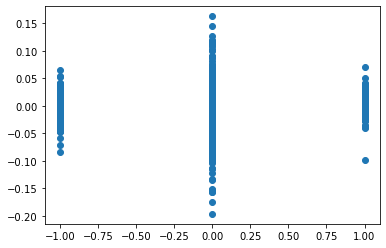

In [302]:
plt.scatter(df.MACD_Signal, df["N5D_Return_Delayed%"])

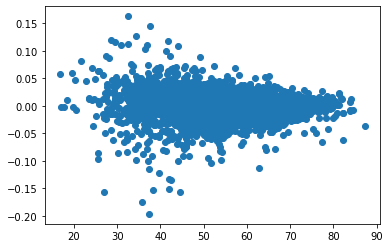

In [303]:
plt.scatter(df.RSI, df["N5D_Return_Delayed%"])

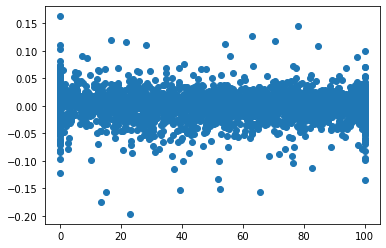

In [304]:
plt.scatter(df.Fast_K, df["N5D_Return_Delayed%"])

## Trading Signal-Based Strategies
More info: https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html

### Buy and Hold

In [42]:
class BuyAndHold(Strategy):
    # This strategy actually starts at day 2 of the time period because of the next() method
    def init(self):
        next
    def next(self):
        self.buy()

### SMA Cross

In [22]:
class SmaCross(Strategy):
    # Define parameters of the strategy
    fast = 3
    slow = 15
    long_only = 1
    
    def init(self):
        # Compute moving averages
        self.fast_sma = self.I(SMA, self.data.Close, self.fast)
        self.slow_sma = self.I(SMA, self.data.Close, self.slow)
            
    def next(self):
        # If fast SMA crosses above slow SMA
        if crossover(self.fast_sma, self.slow_sma):
            if self.long_only == 0:
                self.position.close()
            self.buy()

        # Else, if fast SMA crosses below slow SMA
        elif crossover(self.slow_sma, self.fast_sma):
            self.position.close()
            if self.long_only == 0:
                self.sell()

### MACD

More info: https://www.investopedia.com/terms/m/macd.asp

In [23]:
class MacdSignal(Strategy): 
    # Define parameters of the strategy
    fastperiod = 12
    slowperiod = 26
    signalperiod = 9
    long_only = 1
    
    def init(self):
        # Compute MACD
        self.macd, self.macdsignal, self.macdhist = self.I(
             MACD, self.data.Close, self.fastperiod, self.slowperiod, self.signalperiod)
        
    def next(self):
        # If MACD crosses above signal line
        if crossover(self.macd, self.macdsignal):
            if self.long_only == 0:
                self.position.close()
            self.buy()

        # Else, if MACD crosses below signal line
        elif crossover(self.macdsignal, self.macd):
            self.position.close()
            if self.long_only == 0:
                self.sell()

### RSI
More info: https://www.investopedia.com/terms/r/rsi.asp

In [24]:
class RsiSignal(Strategy): 
    # Define parameters of the strategy
    timeperiod = 14
    overbought = 70
    oversold = 30
    long_only = 1
    
    def init(self):
        # Compute RSI
        self.real = self.I(RSI, self.data.Close, self.timeperiod)
        
    def next(self):
        # If RSI enters oversold territory
        if self.real <= self.oversold:
            if self.long_only == 0:
                self.position.close()
            self.buy()
        
        # If RSI enters overbought territory
        elif self.real >= self.overbought:
            self.position.close()
            if self.long_only == 0:
                self.sell()

### Stochastic Oscillator
More info: https://www.investopedia.com/terms/s/stochasticoscillator.asp

In [44]:
class StochOsci(Strategy): 
    # Define parameters of the strategy
    fastk_period = 14
    slowk_period = 3
    slowk_matype = 0
    slowd_period = 3
    slowd_matype = 0
    overbought = 80
    oversold = 20
    long_only = 1
    
    def init(self):
        # Compute K and D lines
        self.slowk, self.slowd = self.I(STOCH, self.data.High, self.data.Low, self.data.Close, 
                                        self.fastk_period, self.slowk_period, self.slowk_matype, 
                                        self.slowd_period, self.slowd_matype)
        
    def next(self):
        # If K and D enter oversold territory
        if self.slowk <= self.oversold and self.slowd < self.oversold:
            if self.long_only == 0:
                self.position.close()
            self.buy()
        
        # If K and D enter overbought territory
        elif self.slowk >= self.overbought and self.slowd > self.overbought:
            self.position.close()
            if self.long_only == 0:
                self.sell()

### Stochastic RSI
More info: https://www.investopedia.com/terms/s/stochrsi.asp

In [45]:
class StochRsi(Strategy): 
    # Define parameters of the strategy
    timeperiod = 14
    fastk_period = 14
    fastd_period = 3
    fastd_matype = 0
    overbought = 80
    oversold = 20
    long_only = 1
    
    def init(self):
        # Compute K and D lines
        self.fastk, self.fastd = self.I(STOCHRSI, self.data.Close, self.timeperiod,
                                        self.fastk_period, self.fastd_period, self.fastd_matype)
        
    def next(self):
        # If K and D enter oversold territory
        if self.fastk < self.oversold and self.fastd < self.oversold:
            if self.long_only == 0:
                self.position.close()
            self.buy()
        
        # If K and D enter overbought territory
        elif self.fastk > self.overbought and self.fastd > self.overbought:
            self.position.close()
            if self.long_only == 0:
                self.sell()

## Backtesting Strategies
Additional info: https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html

In [125]:
# Specify data timeframe and strategy to test
# Get data from Yahoo
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# can also use specify: data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30")
# S&P500 index: ^GSPC
data = yf.download("SPY", period="2y")
strategy = RsiSignal

# Run backtesting
bt = Backtest(data, strategy, cash=100_000, commission=0)
stats = bt.run()

# Display stats and plot results
print(stats)
bt.plot()

[*********************100%***********************]  1 of 1 completed
Start                     2019-02-27 00:00:00
End                       2021-02-26 00:00:00
Duration                    730 days 00:00:00
Exposure Time [%]                   27.920792
Equity Final [$]                109572.676331
Equity Peak [$]                 109572.676331
Return [%]                           9.572676
Buy & Hold Return [%]                36.23208
Return (Ann.) [%]                    4.667494
Volatility (Ann.) [%]               22.970462
Sharpe Ratio                         0.203195
Sortino Ratio                        0.297967
Calmar Ratio                         0.158918
Max. Drawdown [%]                   -29.37049
Avg. Drawdown [%]                   -5.355024
Max. Drawdown Duration      210 days 00:00:00
Avg. Drawdown Duration       42 days 00:00:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                        7.52335
Worst Trade

In [28]:
# Contains individual trade data
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,39,25,58,255.699997,282.369995,1040.129929,0.104302,2020-03-30,2020-05-15,46 days
1,37,60,78,294.350006,298.019989,135.789368,0.012468,2020-05-19,2020-06-15,27 days
2,35,82,83,314.170013,307.989990,-216.300812,-0.019671,2020-06-19,2020-06-22,3 days
3,34,91,138,314.239990,337.549988,792.539917,0.074179,2020-07-02,2020-09-09,69 days
4,34,154,169,337.690002,342.959991,179.179626,0.015606,2020-10-01,2020-10-22,21 days
5,34,180,212,349.929993,368.279999,623.900208,0.052439,2020-11-06,2020-12-23,47 days
6,33,215,236,373.809998,375.630005,60.060242,0.004869,2020-12-29,2021-01-29,31 days
7,32,240,252,382.959991,384.660004,54.400391,0.004439,2021-02-04,2021-02-23,19 days


In [29]:
# Contains equity/drawdown curves. DrawdownDuration is only defined at ends of DD periods.
stats['_equity_curve']

,Equity,DrawdownPct,DrawdownDuration
2020-02-24,10000.000000,0.000000,NaT
2020-02-25,10000.000000,0.000000,NaT
2020-02-26,10000.000000,0.000000,NaT
2020-02-27,10000.000000,0.000000,NaT
2020-02-28,10000.000000,0.000000,NaT
...,...,...,...
2021-02-17,12917.059219,0.000619,NaT
2021-02-18,12863.618790,0.004754,NaT
2021-02-19,12841.538712,0.006462,NaT
2021-02-22,12745.538712,0.013889,NaT


Memo: other examples: https://kernc.github.io/backtesting.py/doc/examples/Trading%20with%20Machine%20Learning.html

### Backtesting Strategy Reliability On Multiple Years

In [51]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# can also use specify: data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30")
recent_periods = ["6mo", "1y"]
year_periods = [("2015-12-31", "2016-12-31"), ("2016-12-31", "2017-12-31"),
               ("2017-12-31", "2018-12-31"), ("2018-12-31", "2019-12-31"), 
               ("2019-12-31", "2020-12-31")]

strategy = SmaCross

def Backtest_Strategy(ticker, strategy, period):
    
    # Download data depending on type specification
    if type(period) == str:
        data = yf.download(ticker, period=period)
    else:
        data = yf.download(ticker, start=period[0], end=period[1]
    
    # Run backtesting
    bt = Backtest(data, strategy, cash=100_000, commission=0)
    stats = bt.run()
    
    strategy_overview[""]


##### WORKING ON THIS #####
stats["Sharpe Ratio"]

[*********************100%***********************]  1 of 1 completed


1.561166786420676

In [59]:
today = datetime.date.today()
print(today)

2021-02-23


In [61]:
period = ("2016-12-31", "2017-12-31")
period[0]

'2016-12-31'